### Import libraries and data

In [2]:
# Import Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree

import datetime
from datetime import date
import random


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import Data
data = pd.read_csv('./data/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [4]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [5]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H')

In [6]:
data = data.set_index(pd.DatetimeIndex(data['date_time'])).rename(columns={"date_time": "ds"}).drop_duplicates(subset=['ds'])

In [7]:
ts = data['2018-06-30':'2018-09-29']
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2018-06-30 00:00:00,None,302.87,0.0,0.0,1,Clear,sky is clear,2018-06-30 00:00:00,1423
2018-06-30 01:00:00,None,302.58,0.0,0.0,1,Clear,sky is clear,2018-06-30 01:00:00,869
2018-06-30 02:00:00,None,302.55,0.0,0.0,1,Thunderstorm,proximity thunderstorm,2018-06-30 02:00:00,617
2018-06-30 03:00:00,None,302.29,0.0,0.0,40,Rain,moderate rain,2018-06-30 03:00:00,429
2018-06-30 04:00:00,None,301.29,0.0,0.0,1,Rain,light rain,2018-06-30 04:00:00,429


Train/Test Split

In [8]:
split_date = '2018-09-22'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

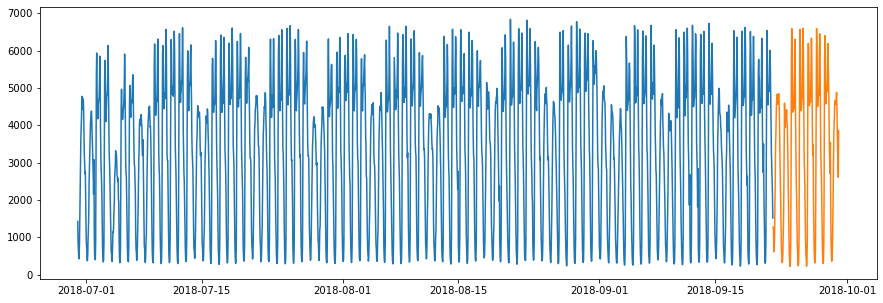

In [9]:
plt.figure(figsize=(15,5))
plt.plot(ts_train.traffic_volume)
plt.plot(ts_test.traffic_volume)
plt.show()

### Create Time Series Features

In [29]:
def create_features(df, label=None, all_features=False):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    if all_features:
        X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear',
                'holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description']]
    else :
        X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [34]:
X_train, y_train = create_features(ts_train, label='traffic_volume', all_features=False)
X_test, y_test = create_features(ts_test, label='traffic_volume', all_features=False)

In [27]:
### Create XGboost model with only time features

In [12]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

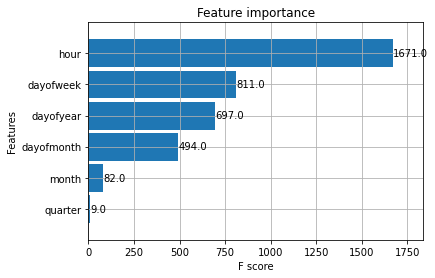

In [14]:
plot_importance(reg, height=0.9)

##### Predict on test data

In [15]:
y_pred = reg.predict(X_test)

##### Error Metrics

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
def error_metrics(y_true, y_pred):
    print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('Mean Absolute percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred)))

In [22]:
#Calculate Model error
error_metrics(ts_test.traffic_volume, y_pred)

Mean Absolute Error: 195.68
Root Mean Squared Error: 292.06
Mean Absolute percentage Error: 11.25 %


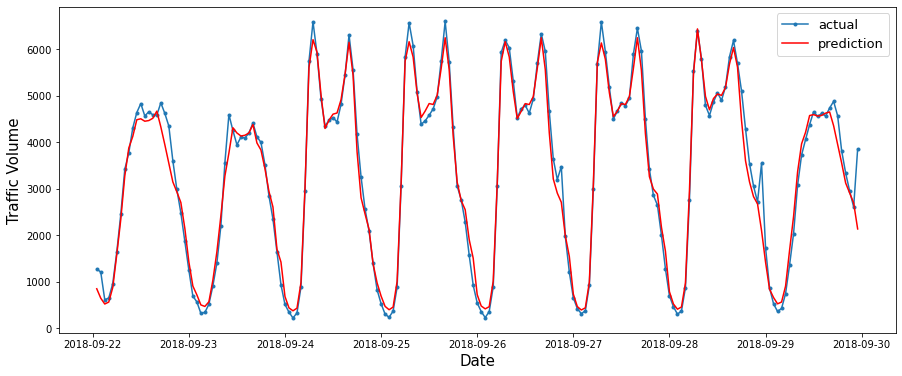

In [25]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

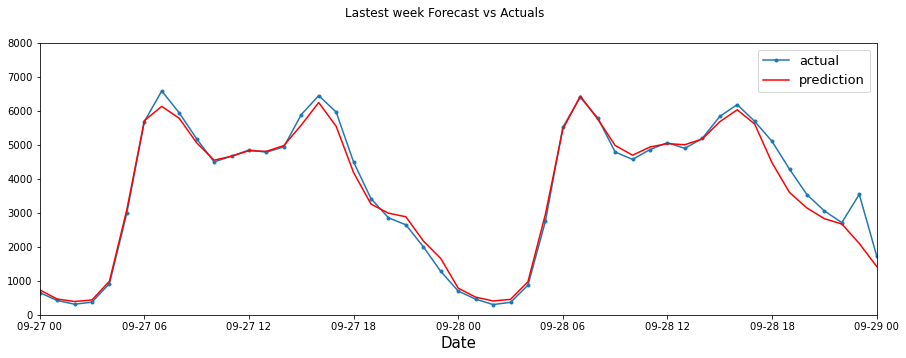

In [26]:
# zoom on lastest 2 days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

In [36]:
### Create XGboost model with all features

In [37]:
X_train, y_train = create_features(ts_train, label='traffic_volume', all_features=True)
X_test, y_test = create_features(ts_test, label='traffic_volume', all_features=True)

In [43]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [63]:
# Feature engineering
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, make_column_selector(dtype_include="object")),
        ("num", numeric_transformer, make_column_selector(dtype_exclude="object")),
    ]
)

In [64]:
my_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

In [65]:
# Transform the data
X_train = my_pipeline.fit_transform(X_train)
X_test = my_pipeline.transform(X_test)

In [66]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

##### Predict on test data

In [71]:
y_pred = reg.predict(X_test)

##### Error Metrics

In [74]:
#Calculate Model error
error_metrics(ts_test.traffic_volume, y_pred)

Mean Absolute Error: 181.18
Root Mean Squared Error: 282.08
Mean Absolute percentage Error: 9.08 %


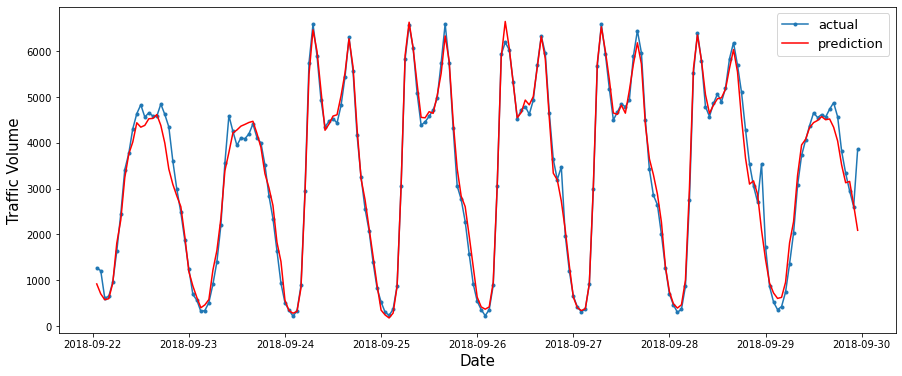

In [75]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

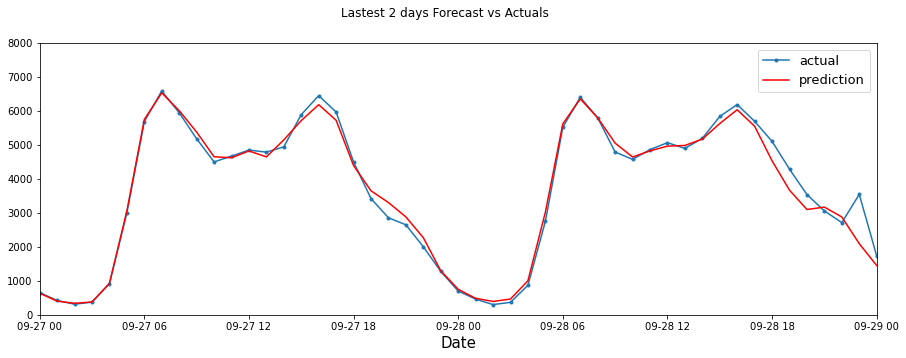

In [77]:
# zoom on lastest 2 days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest 2 days Forecast vs Actuals')

### HyperParmeter Tuning

In [203]:
# gridsearsh
param_grid = {
    "max_depth": [9], #[8, 9, 10],
    "learning_rate": [0.005, 0.01, 0.015],
    "min_child_weight": [1], #[1,2,3],
    #"subsample": [0.8, 0.9],
    #"colsample_bytree": [0.7, 0.8],
    "n_estimators" : [1000],
    #"reg_alpha" : [0, 0.05],
    #"reg_lambda" : [0, 0.05],
}

In [204]:
reg = xgb.XGBRegressor(objective='reg:squarederror')

In [205]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(reg, 
                            param_grid,
                            cv=4,
                            scoring= 'neg_mean_absolute_percentage_error',
                            verbose=4,
                            n_jobs=-1,
                          )

In [206]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
Wall time: 49.3 s


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                 

In [207]:
print(grid_search.best_score_)
print(grid_search.best_params_)

-0.10137541681043033
{'learning_rate': 0.005, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 1000}


In [214]:
reg_opt = xgb.XGBRegressor(**grid_search.best_params_)

In [216]:
reg_opt.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

##### Predict on test data

In [217]:
%%time
y_pred = reg_opt.predict(X_test)

Wall time: 10 ms


##### Error Metrics

In [218]:
#Calculate Model error
error_metrics(ts_test.traffic_volume, y_pred)

Mean Absolute Error: 186.38
Root Mean Squared Error: 295.63
Mean Absolute percentage Error: 7.44 %


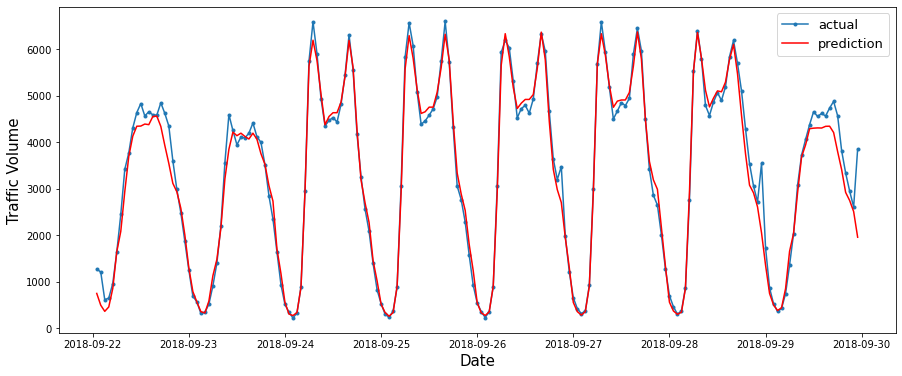

In [219]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

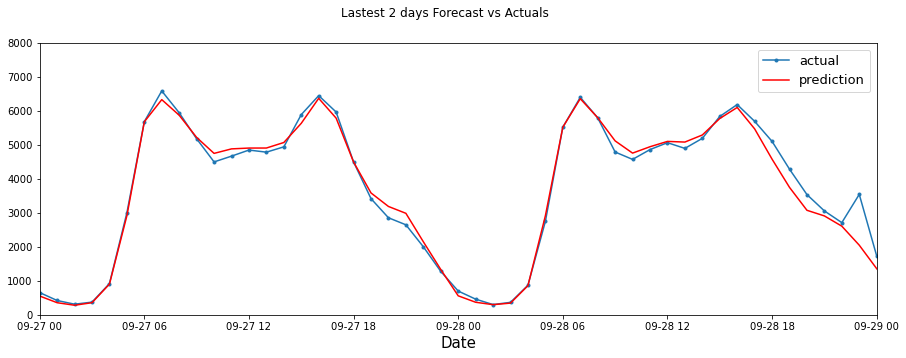

In [220]:
# zoom on lastest 2 days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest 2 days Forecast vs Actuals')